# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import DiadFit as pf
pf.__version__

'0.0.59'

## Specifying filetype, and folder as before

In [23]:
MasterFolder = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018"
DayFolder = os.path.join(MasterFolder, "Leilani_2018FI_Nov2922")
meta_path=DayFolder +  '\Metadata'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')

# This specifies what file type your Raman exported in. 
filetype='headless_txt' # Specifies raman file format 
file_ext='.txt'
prefix=False

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [24]:
## load dataframes and numpy arrays 
np_x = joblib.load('np_x.sav')

# Select the group you want to fit ('Weak', 'Medium', 'Strong')
batch='Medium' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')

In [25]:
GroupN_df

filename rays_present  approx_split  \
0                         LL8_156_FI#4.txt        False    103.260799   
1             LL8_156_FI#5_CRR_DiadFit.txt         True    103.277297   
2  LL8_156_FI#5_1320window_CRR_DiadFit.txt         True    103.359842   
3              LL8_156_FI#5_1324window.txt        False    103.270397   
4             LL8_243_FI#1_CRR_DiadFit.txt         True    103.343331   
5             LL8_406_FI#2_CRR_DiadFit.txt         True    103.288293   
6             LL8_616_FI#1_CRR_DiadFit.txt         True    103.062641   

     Diad1_pos    Diad2_pos      HB1_pos      HB2_pos      C13_pos  \
0  1285.584817  1388.845615  1265.181240  1410.228124  1370.493395   
1  1285.557319  1388.834616  1265.241736  1410.217125  1370.498895   
2  1285.434773  1388.794615  1265.241628  1410.110519  1370.379171   
3  1285.434555  1388.704952  1265.176506  1410.107089  1370.449056   
4  1285.467796  1388.811126  1265.296666  1410.121526  1370.401186   
5  1285.346714  1388.635007  1265.126050  1410.049978  1370.335142   
6  1285.858560  1388.921201  1265.483792  1410.308652  1370.566298   

   Diad1_abs_prom  Diad2_abs_prom  ...  HB2_height  C13_height  Diad1_height  \
0     1205.958393     1986.295642  ...  878.987274  766.221070   1930.958393   
1     1336.189249     2209.134601  ...  855.325625  723.049671   2016.389261   
2     1392.239237     2388.006363  ...  870.238601  724.552084   2074.289240   
3     1296.894521     2372.249497  ...  860.328564  721.095456   1977.894521   
4     1256.878626     2180.430447  ...  833.799230  703.706463   1927.278620   
5      717.233490     1195.723571  ...  774.465246  700.275828   1396.383469   
6      898.657108     1577.948356  ...  803.318232  694.374975   1572.957096   

   HB1_height  Diad1_Median_Bck  Diad2_Median_Bck  C13_HB2_abs_prom_ratio  \
0  813.430567        725.000000        718.199997                3.908567   
1  775.302114        680.200012        678.150009                4.466596   
2  781.939273        682.050003        679.900024                4.976331   
3  782.322605        681.000000        678.650009                4.961158   
4  761.825177        670.399994        670.000000                5.605527   
5  729.607604        679.149979        677.099976                4.643487   
6  744.353143        674.299988        670.799988                6.126261   

   Diad2_HB2_Valley_prom  HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
0               0.999165                  31.133771                  59.321247  
1               1.003091                  61.102172                 114.588302  
2               1.002347                  56.254846                 107.708767  
3               1.003677                  62.340294                 112.729088  
4               0.997318                  62.863514                 112.254324  
5               0.995282                  28.795433                  57.620321  
6               0.997025                  45.697002                  89.797487  

[7 rows x 40 columns]

### Now load one file from this group to tweak parameters for

In [26]:
Diad_Files =GroupN_df['filename']
i=0
Diad_Files[i]

'LL8_156_FI#4.txt'

### Lets plot the diad to have a look at it

LL8_156_FI#4.txt


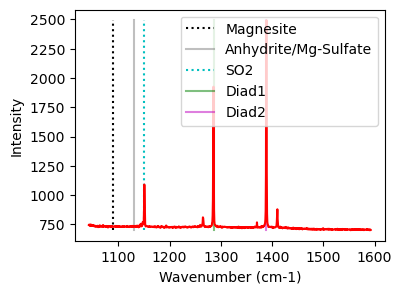

In [27]:
print(GroupN_df['filename'].iloc[i])
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [28]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [29]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=1,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1250),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=1205.958393020426, HB_prom=87.4305671085607, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

Diad1_Combofit_Cent  Diad1_Voigt_Cent  Diad1_cent_err  Diad1_Voigt_Area  \
0           1285.54381        1285.54386        0.001952       1877.239035   

   Diad1_Voigt_Sigma  Diad1_Voigt_Gamma     HB1_Cent    HB1_Area  HB1_Sigma  \
0            0.57296                  0  1265.260094  235.102543   0.849665   

   Diad1_Combofit_Height  Diad1_Residual  Diad1_Prop_Lor  Diad1_fwhm  \
0            1220.047428        3.039862        0.643227    1.145919   

         Diad1_refit  
0  Flagged Warnings:

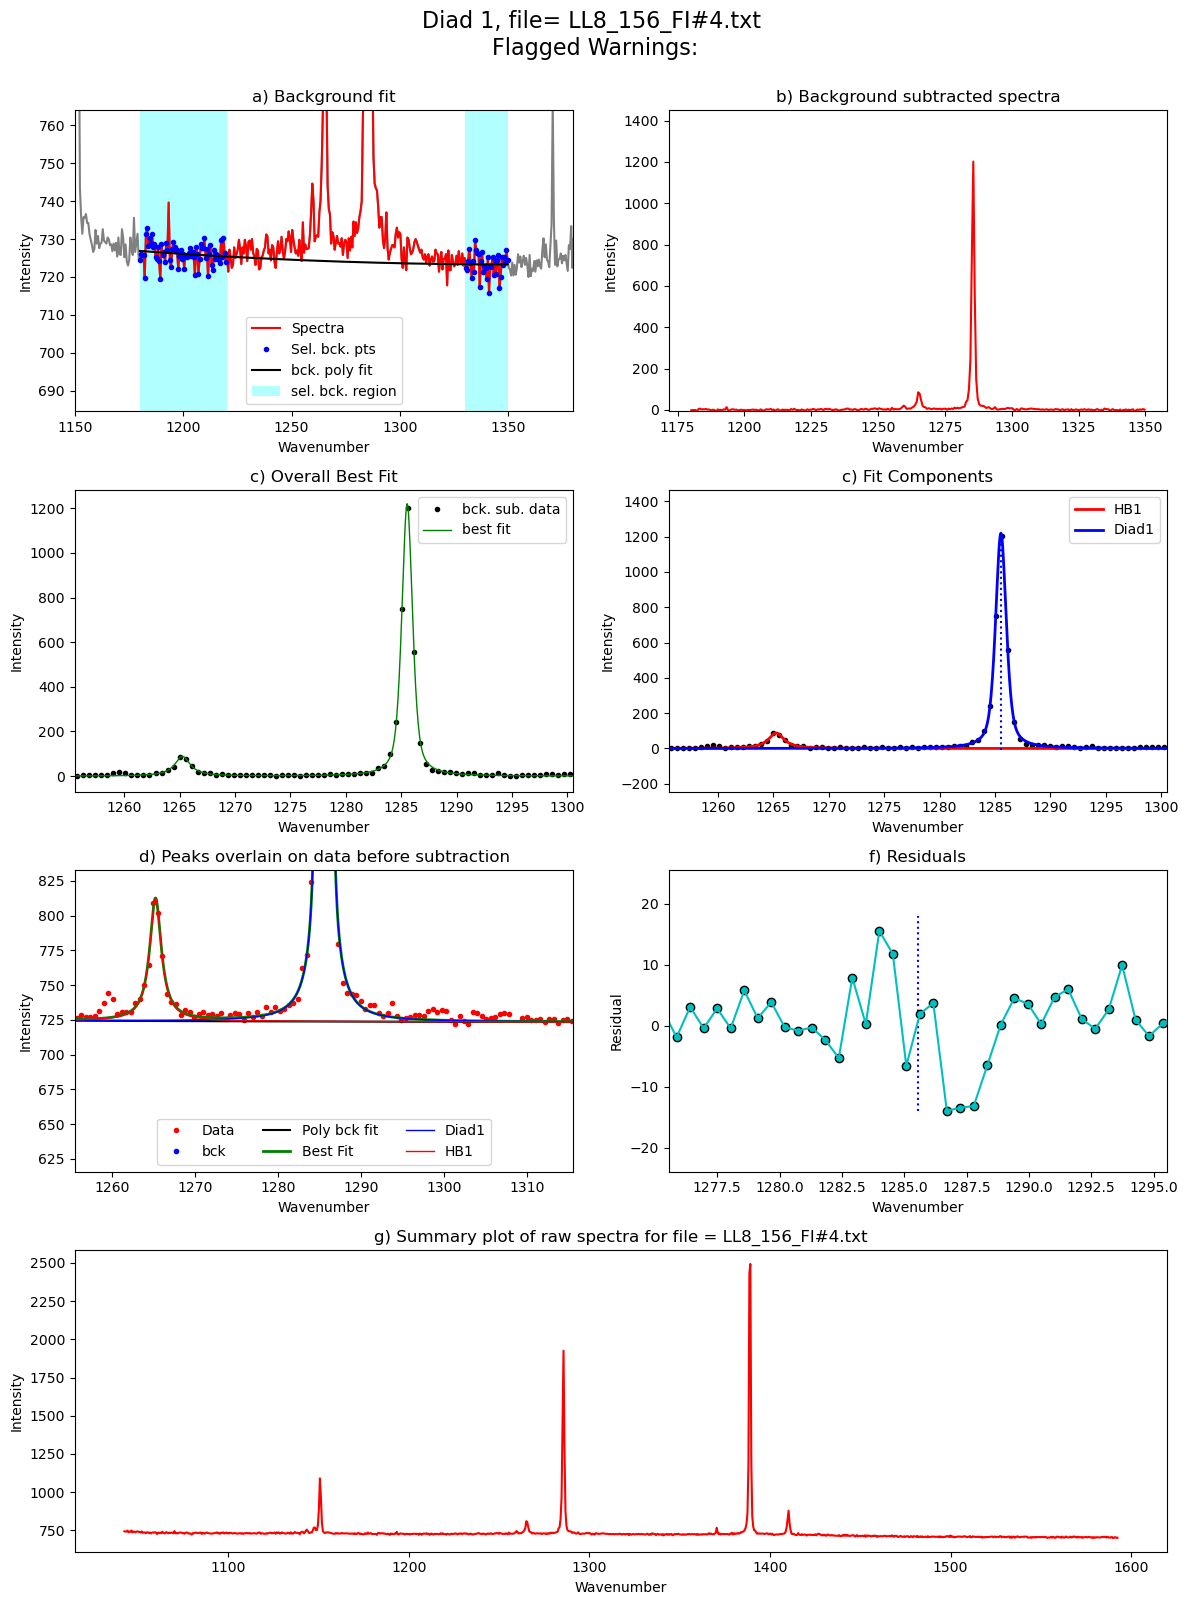

In [30]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=GroupN_df['filename'].iloc[i],
filetype=filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [31]:
diad1_fit_config2=diad1_fit_config_init
diad1_fit_config2.diad_sigma=Diad1_fit['Diad1_Voigt_Sigma'][0]

## Fit diad2

In [32]:
if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=1, upper_bck_diad2=(1430, 1480),
    lower_bck_diad2=(1310, 1360), diad_sigma=0.6,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3,
    lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=3, N_poly_bck_diad2=2, lower_bck_diad2=(1310, 1350), upper_bck_diad2=(1440, 1470), fit_gauss=False, gauss_amp=1000, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=1986.2956415691422, HB_prom=166.58727960360943, x_range_baseline=30, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False, C13_prom=42.62106353912418)

### See what these fit parameters look like for diad2

In [33]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=GroupN_df['filename'].iloc[i], filetype=filetype,
plot_figure=True, close_figure=True, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

Diad2_Combofit_Cent  Diad2_Voigt_Cent  Diad2_cent_err  Diad2_Voigt_Area  \
0          1388.836336       1388.836286        0.001155         2785.0401   

   Diad2_Voigt_Sigma  Diad2_Voigt_Gamma     HB2_Cent    HB2_Area  HB2_Sigma  \
0           0.487069                  0  1410.168807  310.366157   0.608526   

      C13_Cent  C13_Area  C13_Sigma  Diad2_Combofit_Height  Diad2_Residual  \
0  1370.381404   40.1089   0.243005            2195.594164         2.89945   

   Diad2_Prop_Lor  Diad2_fwhm        Diad2_refit  
0        0.566417    0.974139  Flagged Warnings:

### Update the sigma

In [34]:
diad2_fit_config2=diad2_fit_config_init
diad2_fit_config2.diad_sigma=Diad2_fit['Diad2_Voigt_Sigma'][0]
print(Diad2_fit['Diad2_Voigt_Sigma'][0])

0.48706941811727855


## Loop over all the files in the group
- This will loop over all the 

 14%|█▍        | 1/7 [00:02<00:15,  2.58s/it]

refit attempt 1
refit attempt  =2, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =3, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =4, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =5, Flagged Warnings: No Error
Flagged Warnings: No Error
Got to 5 iteratoins and still couldnt adjust the fit parameters


100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


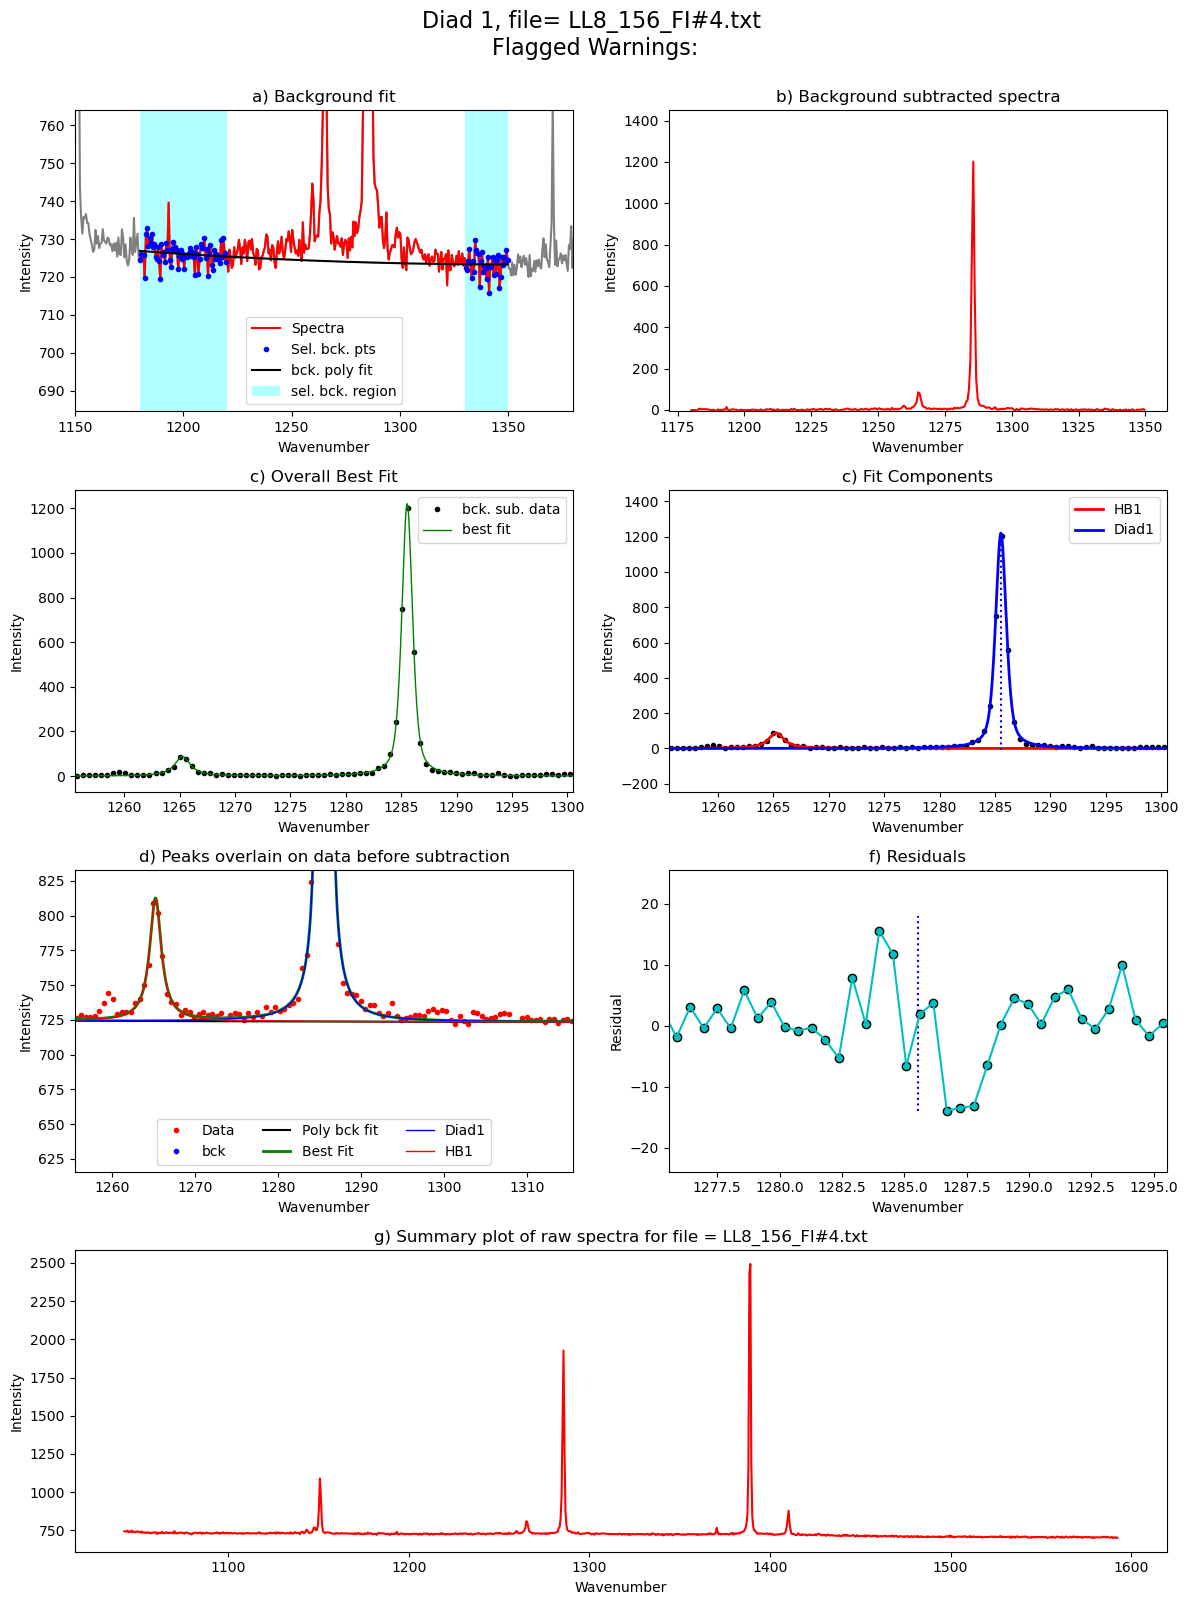

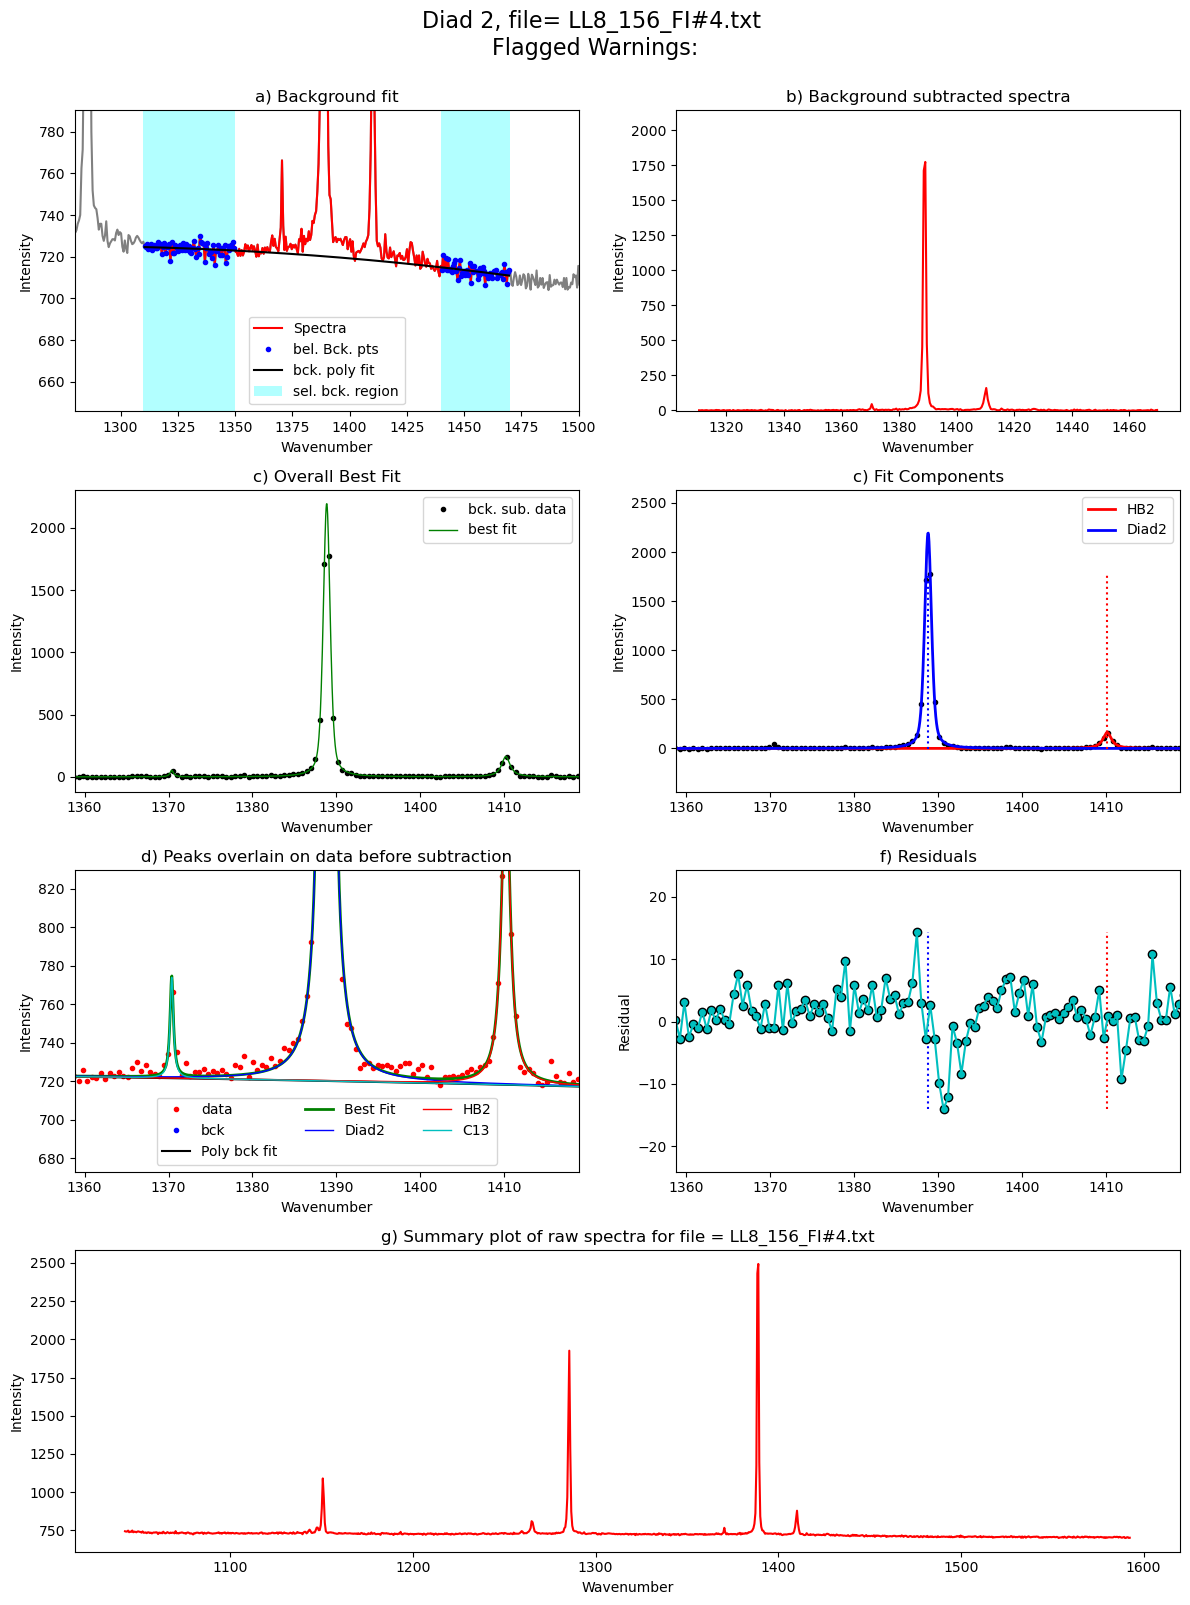

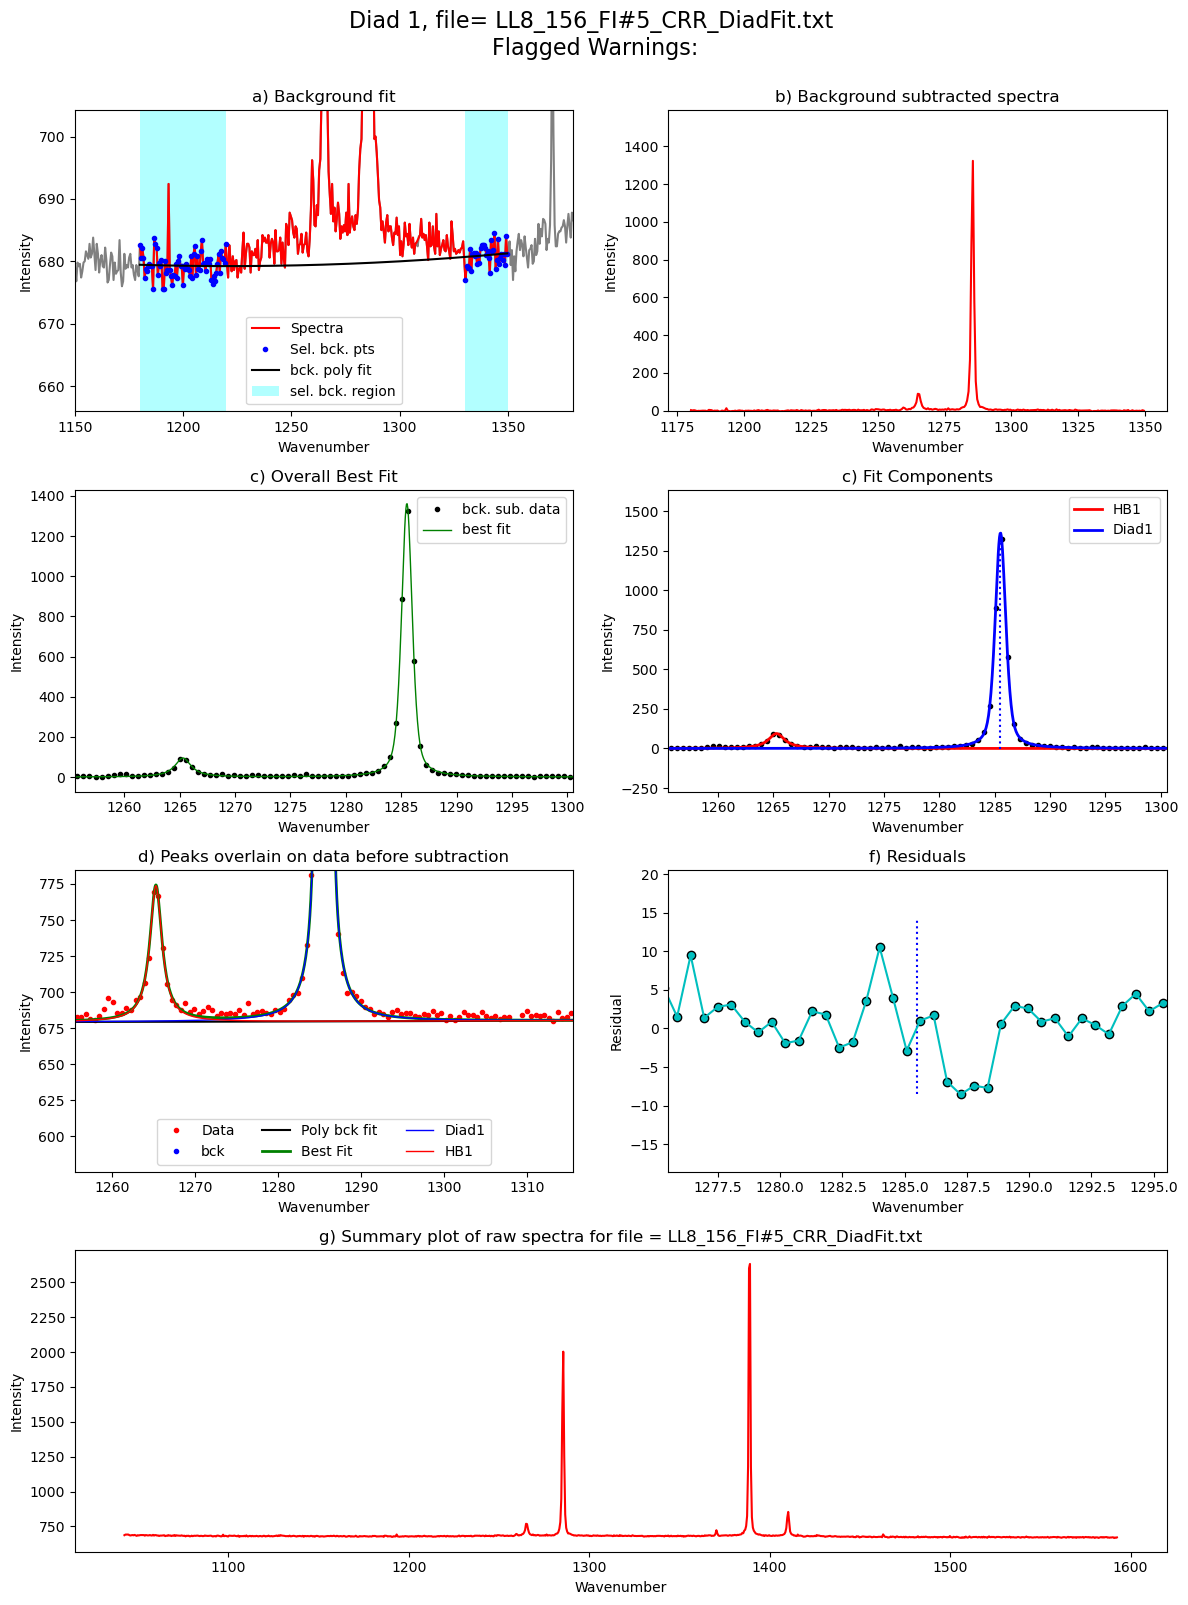

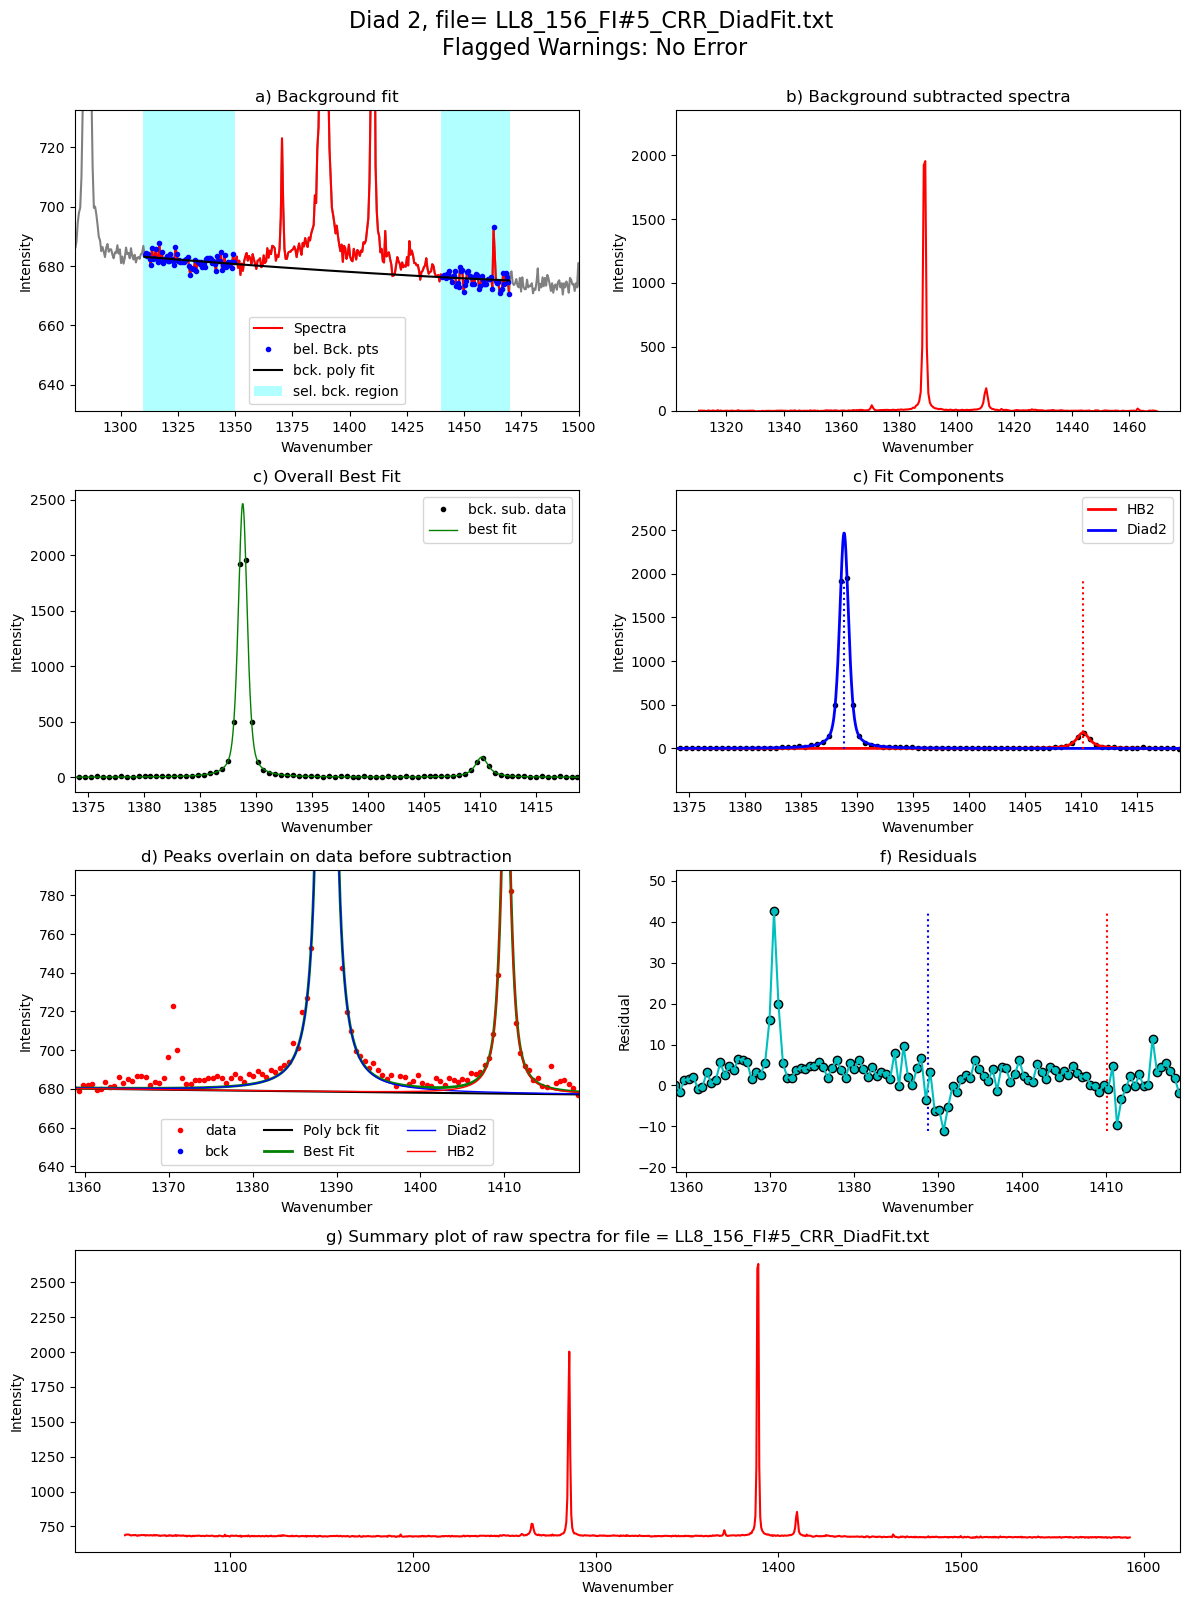

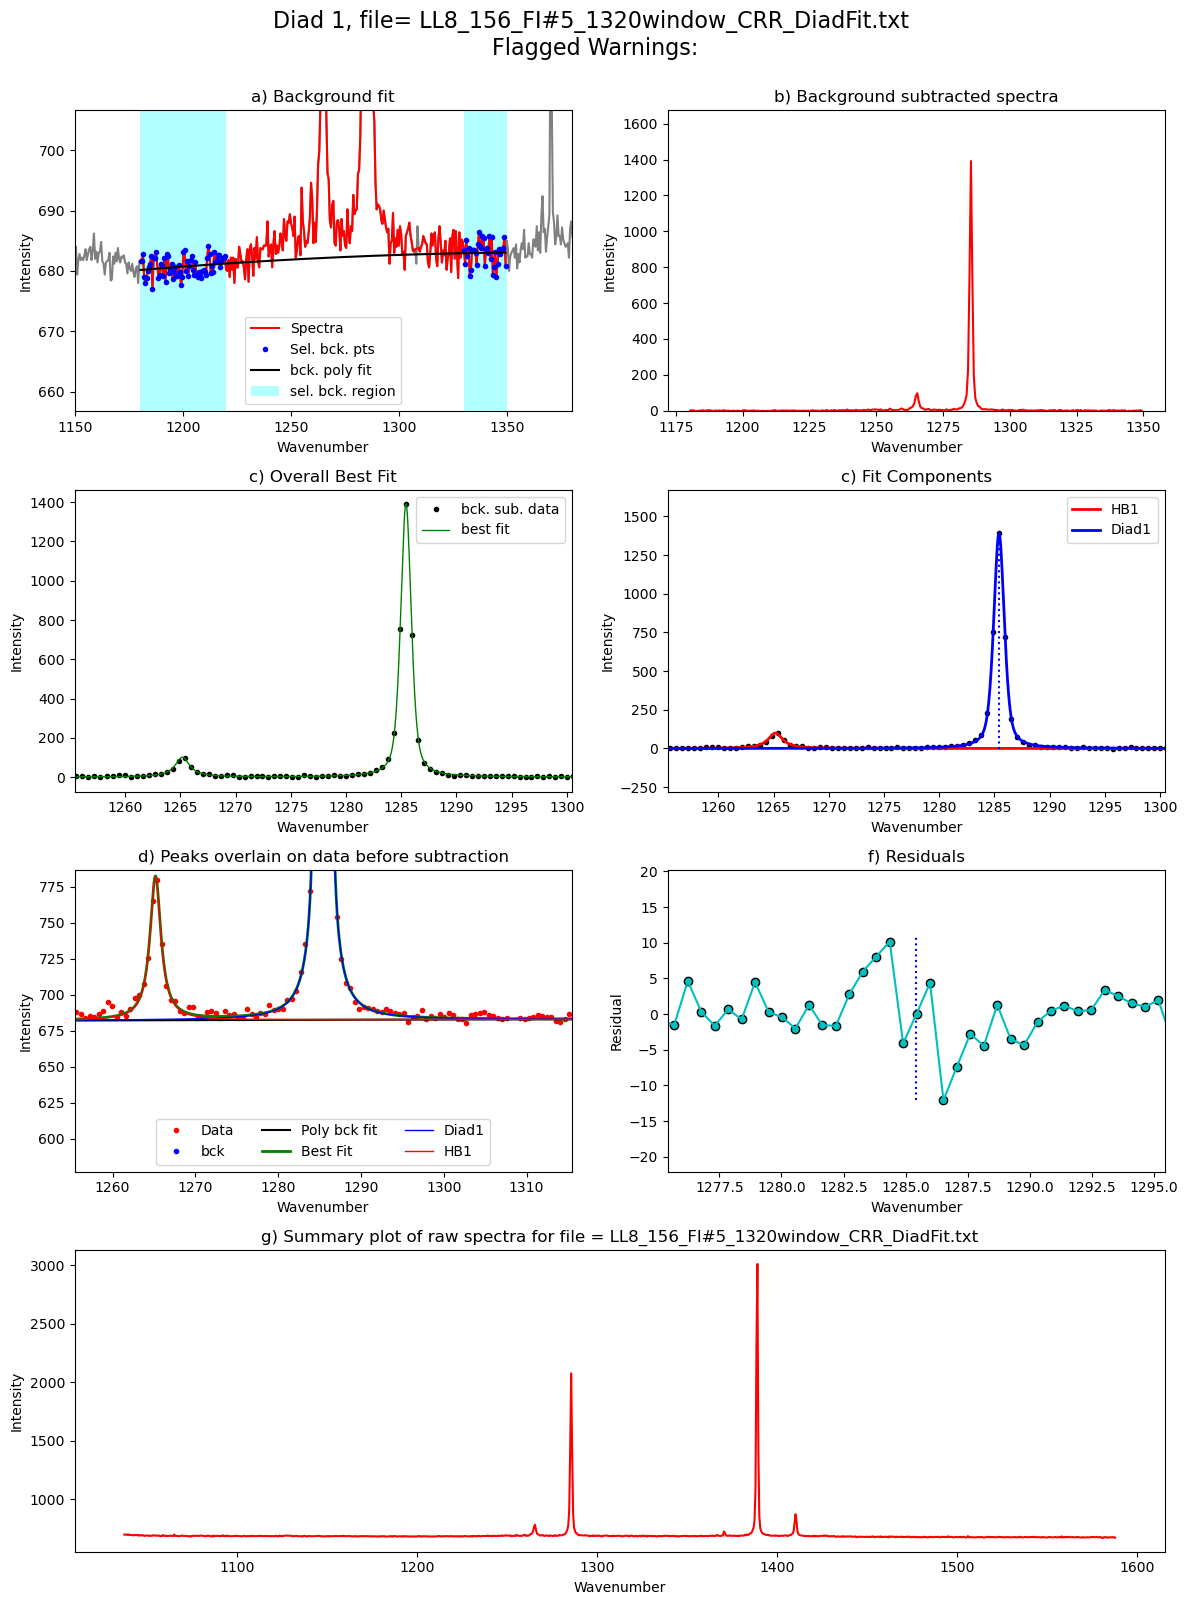

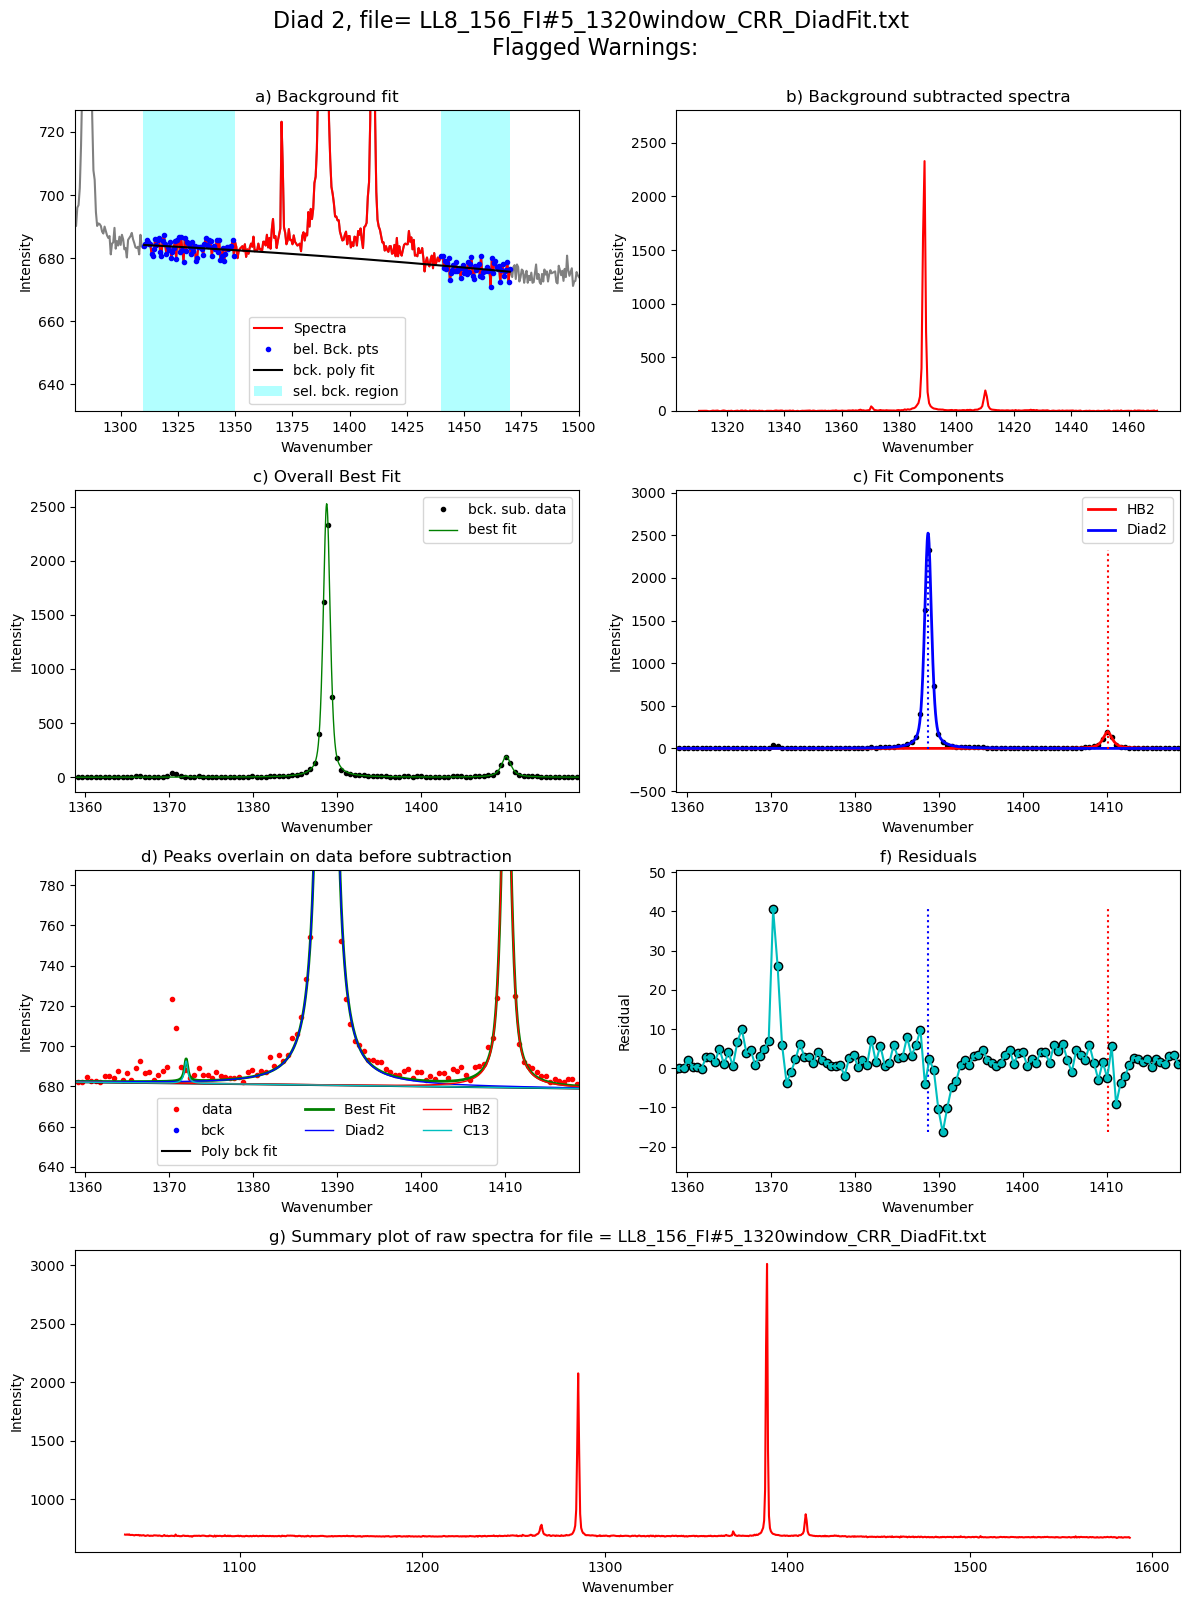

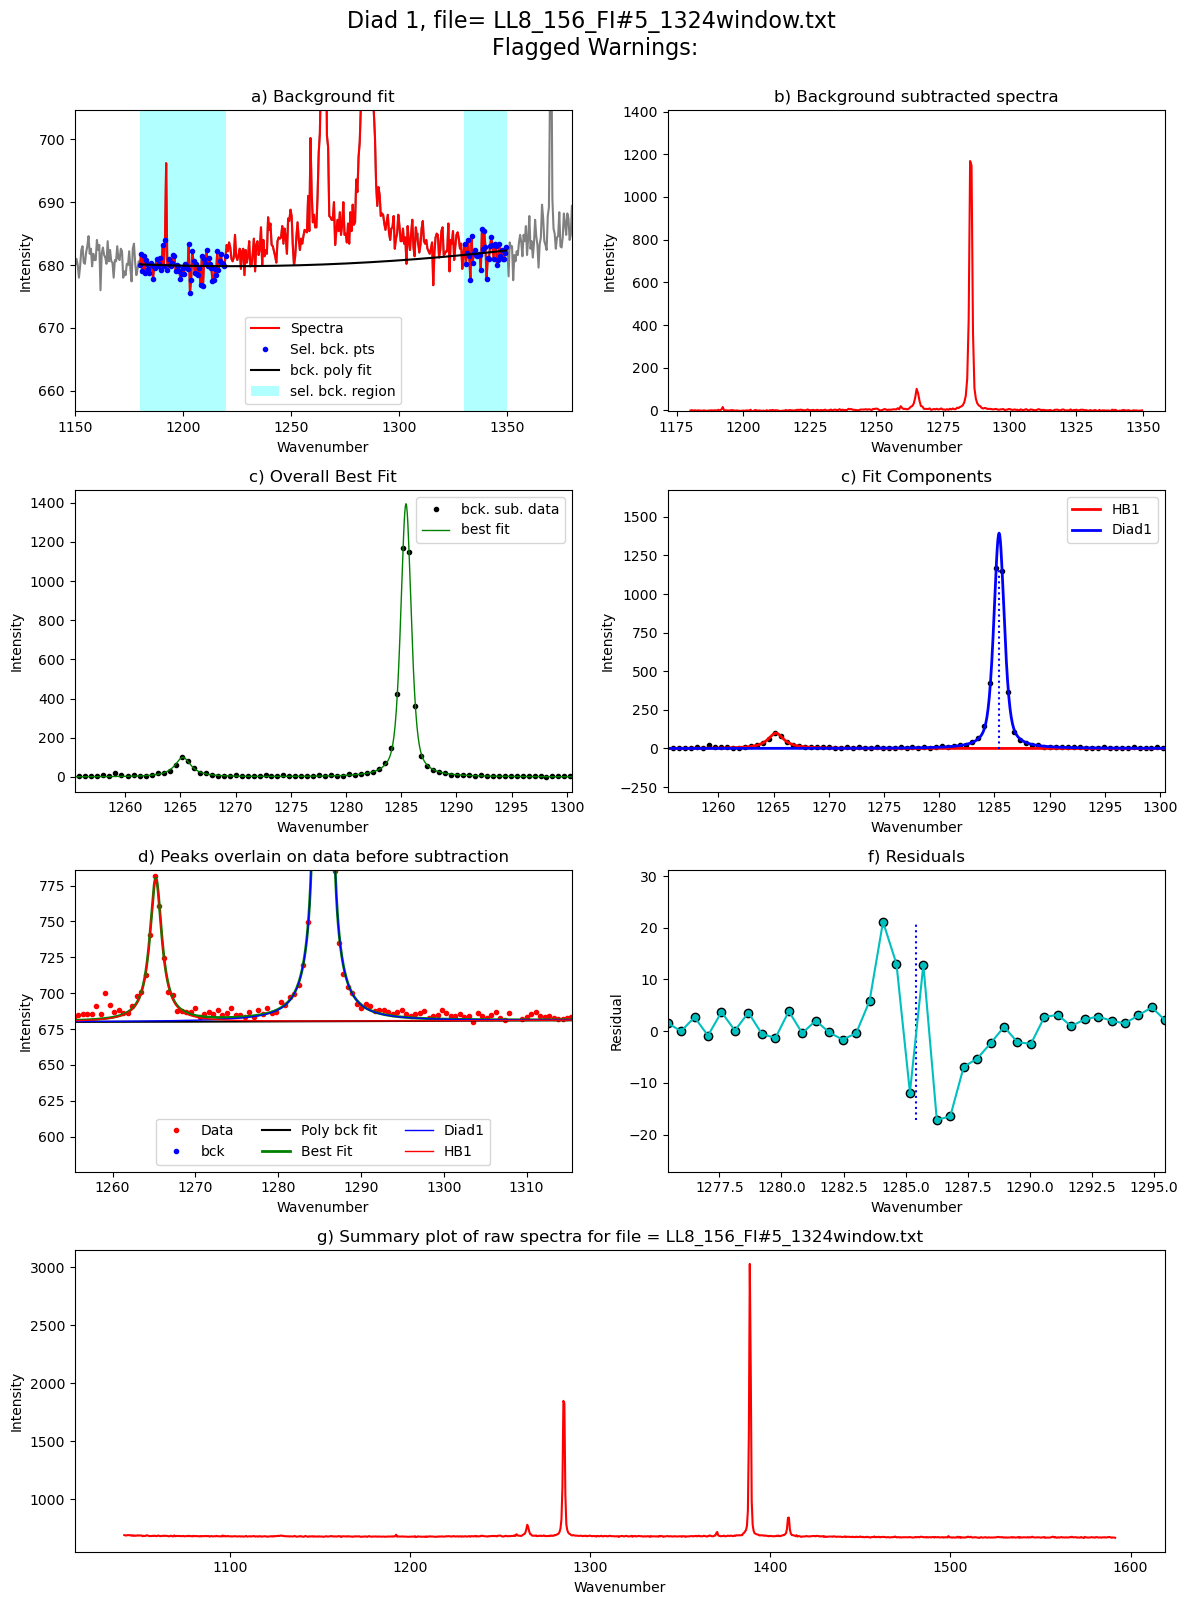

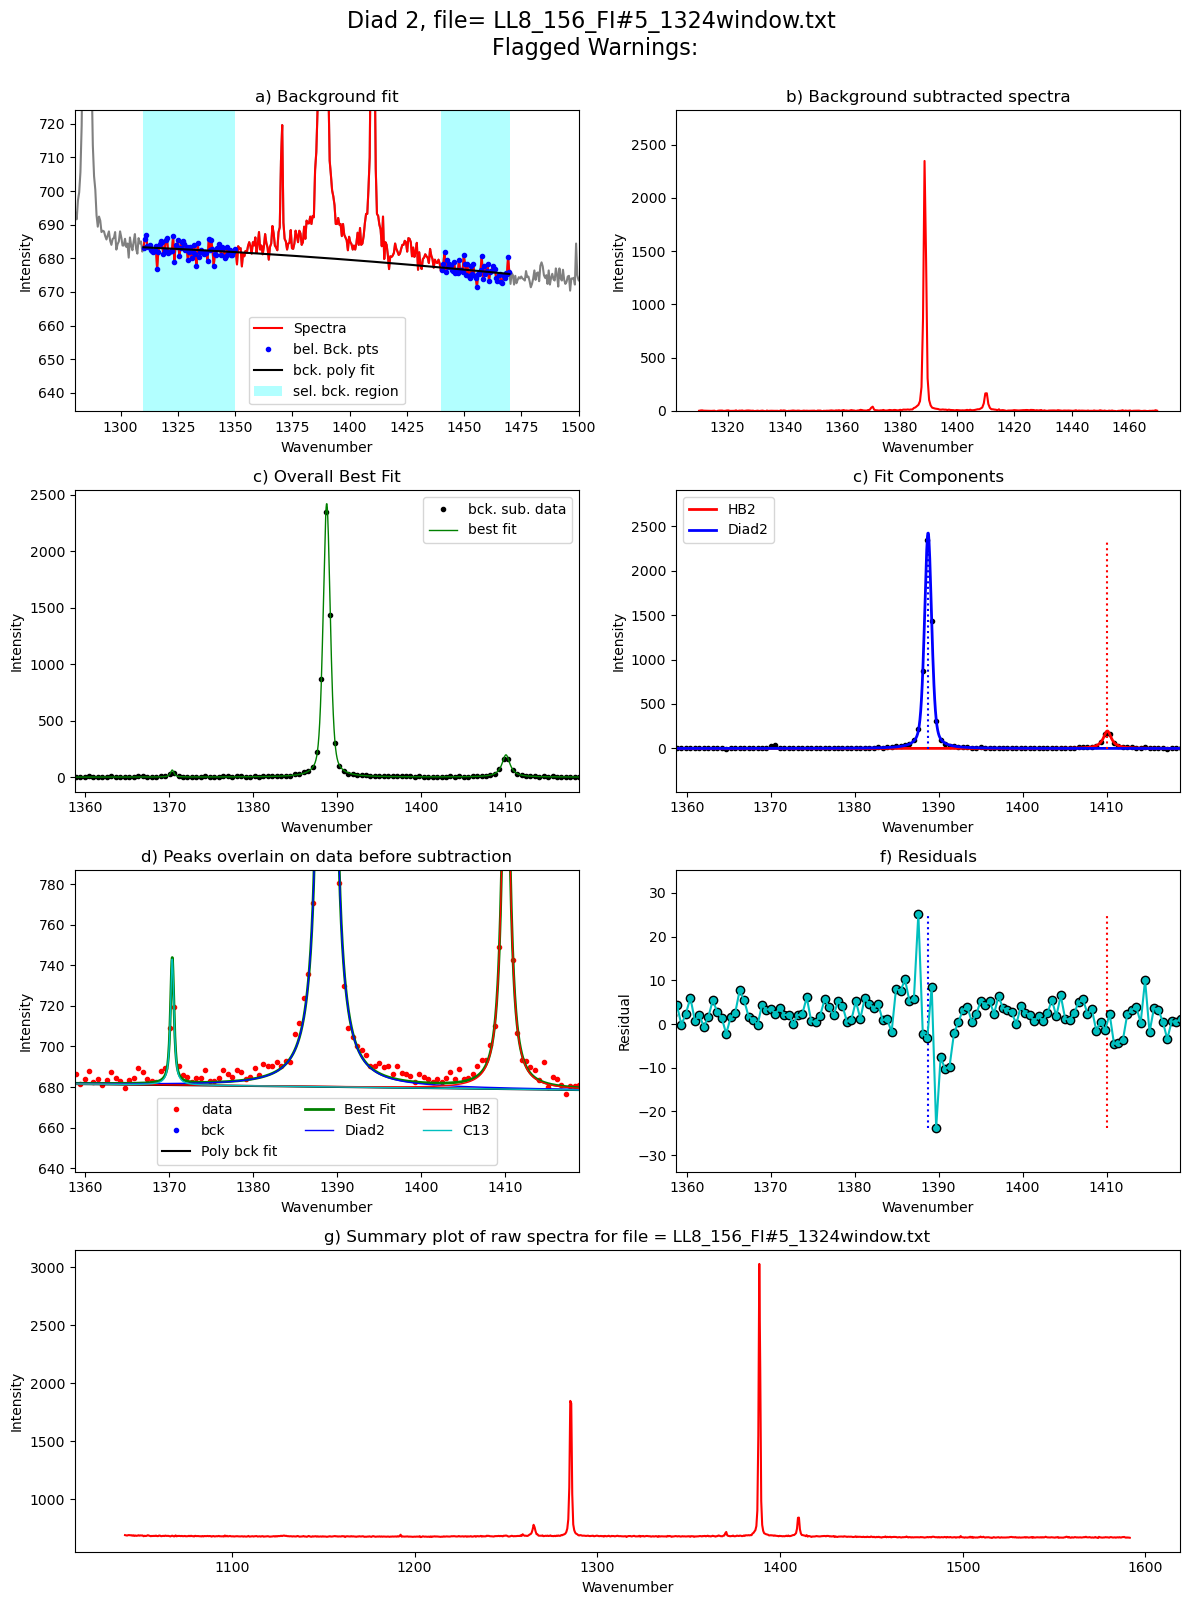

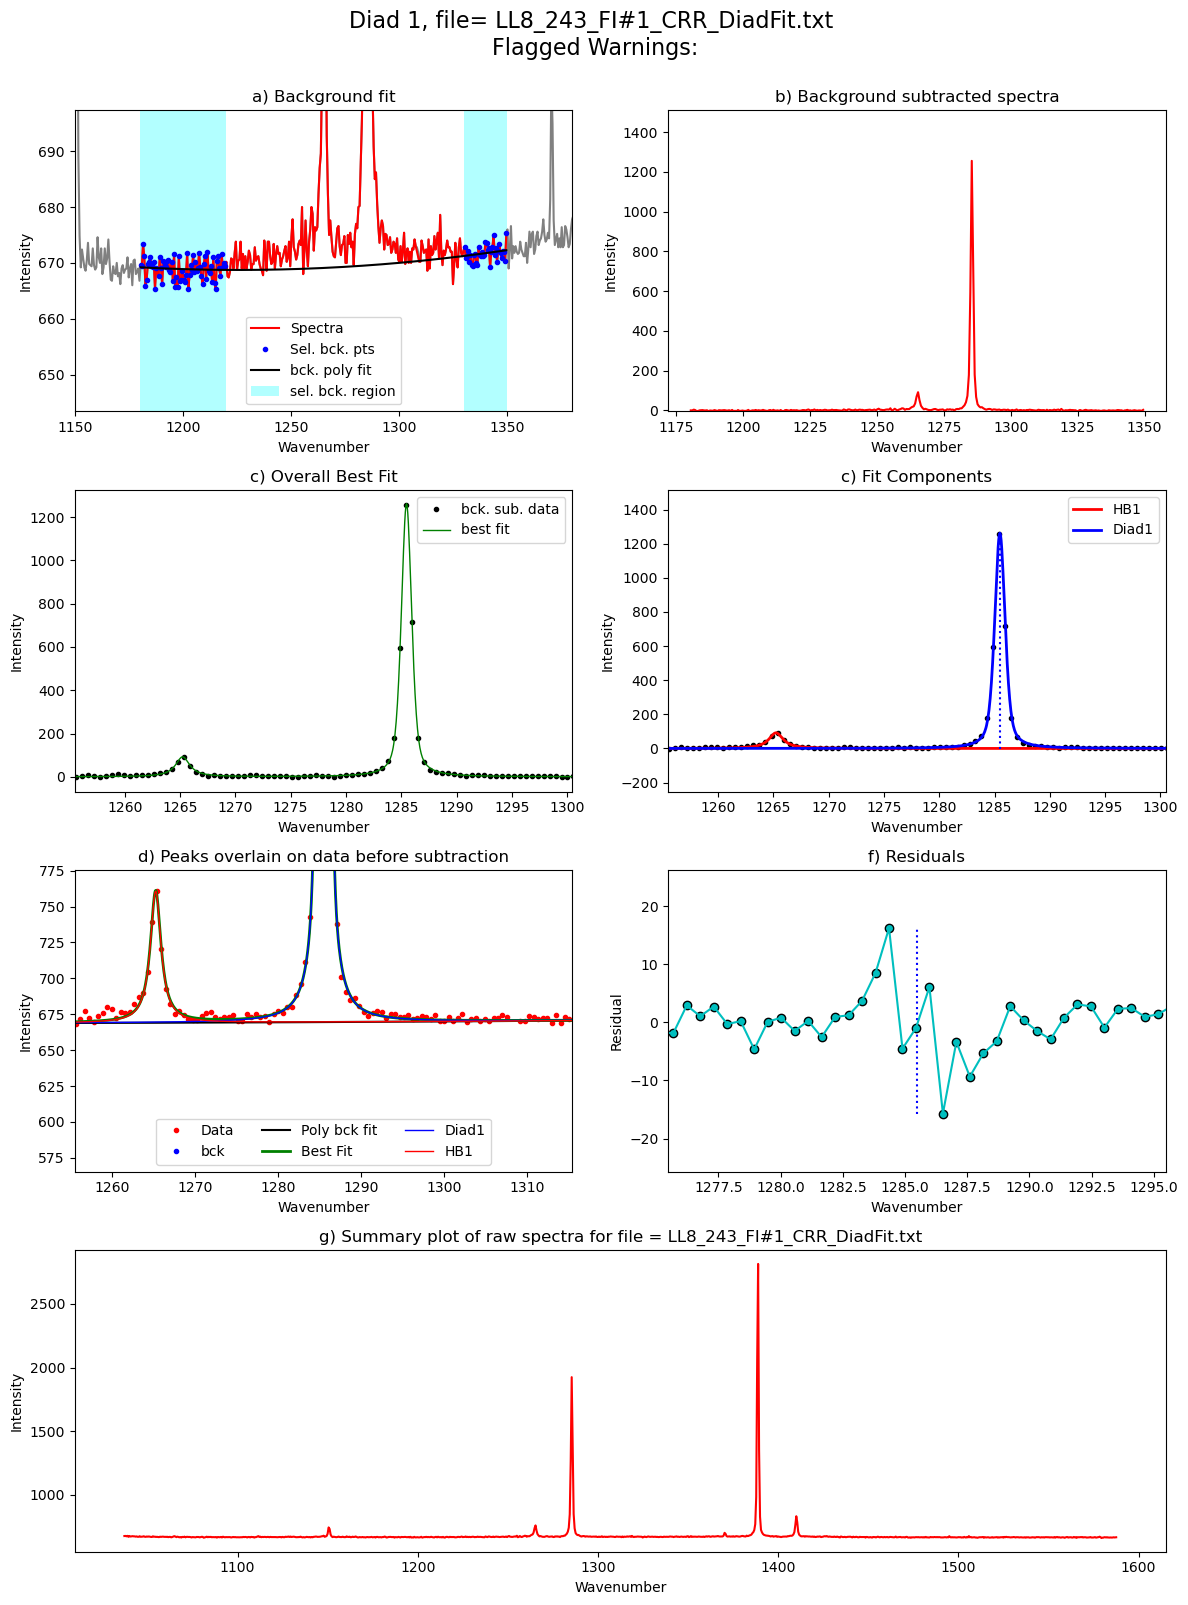

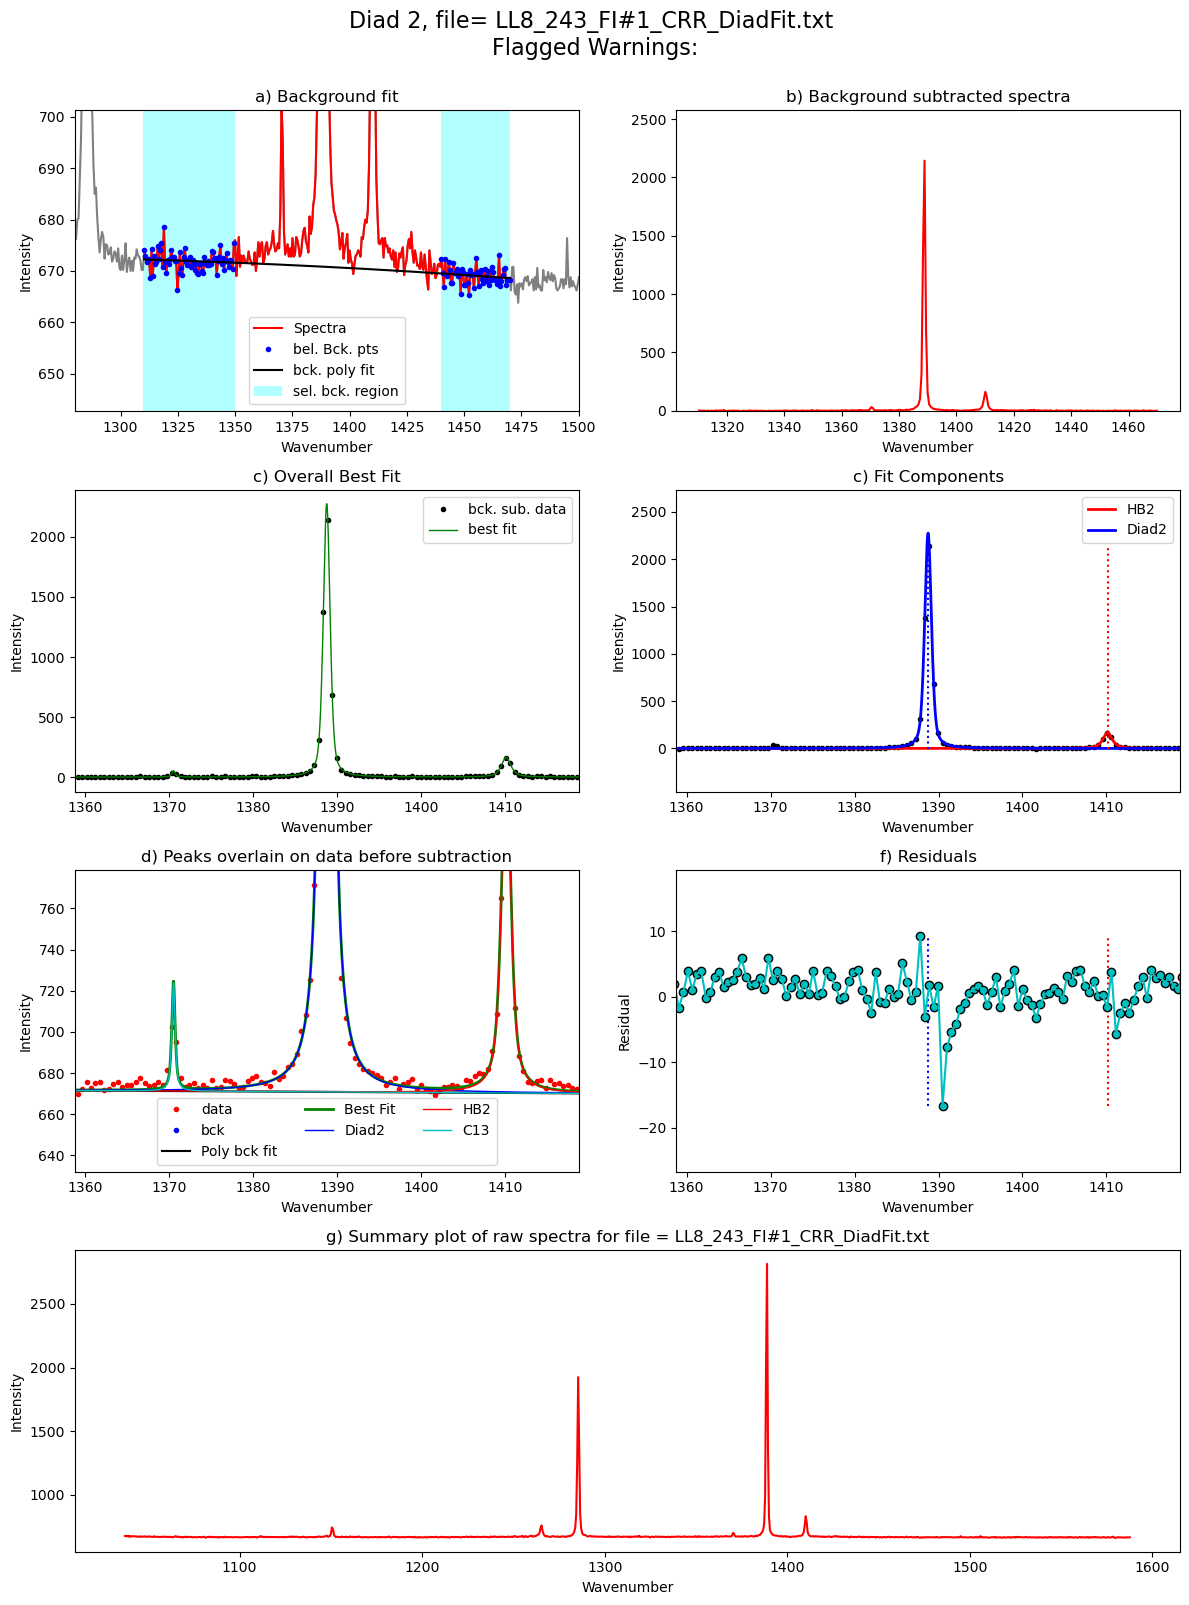

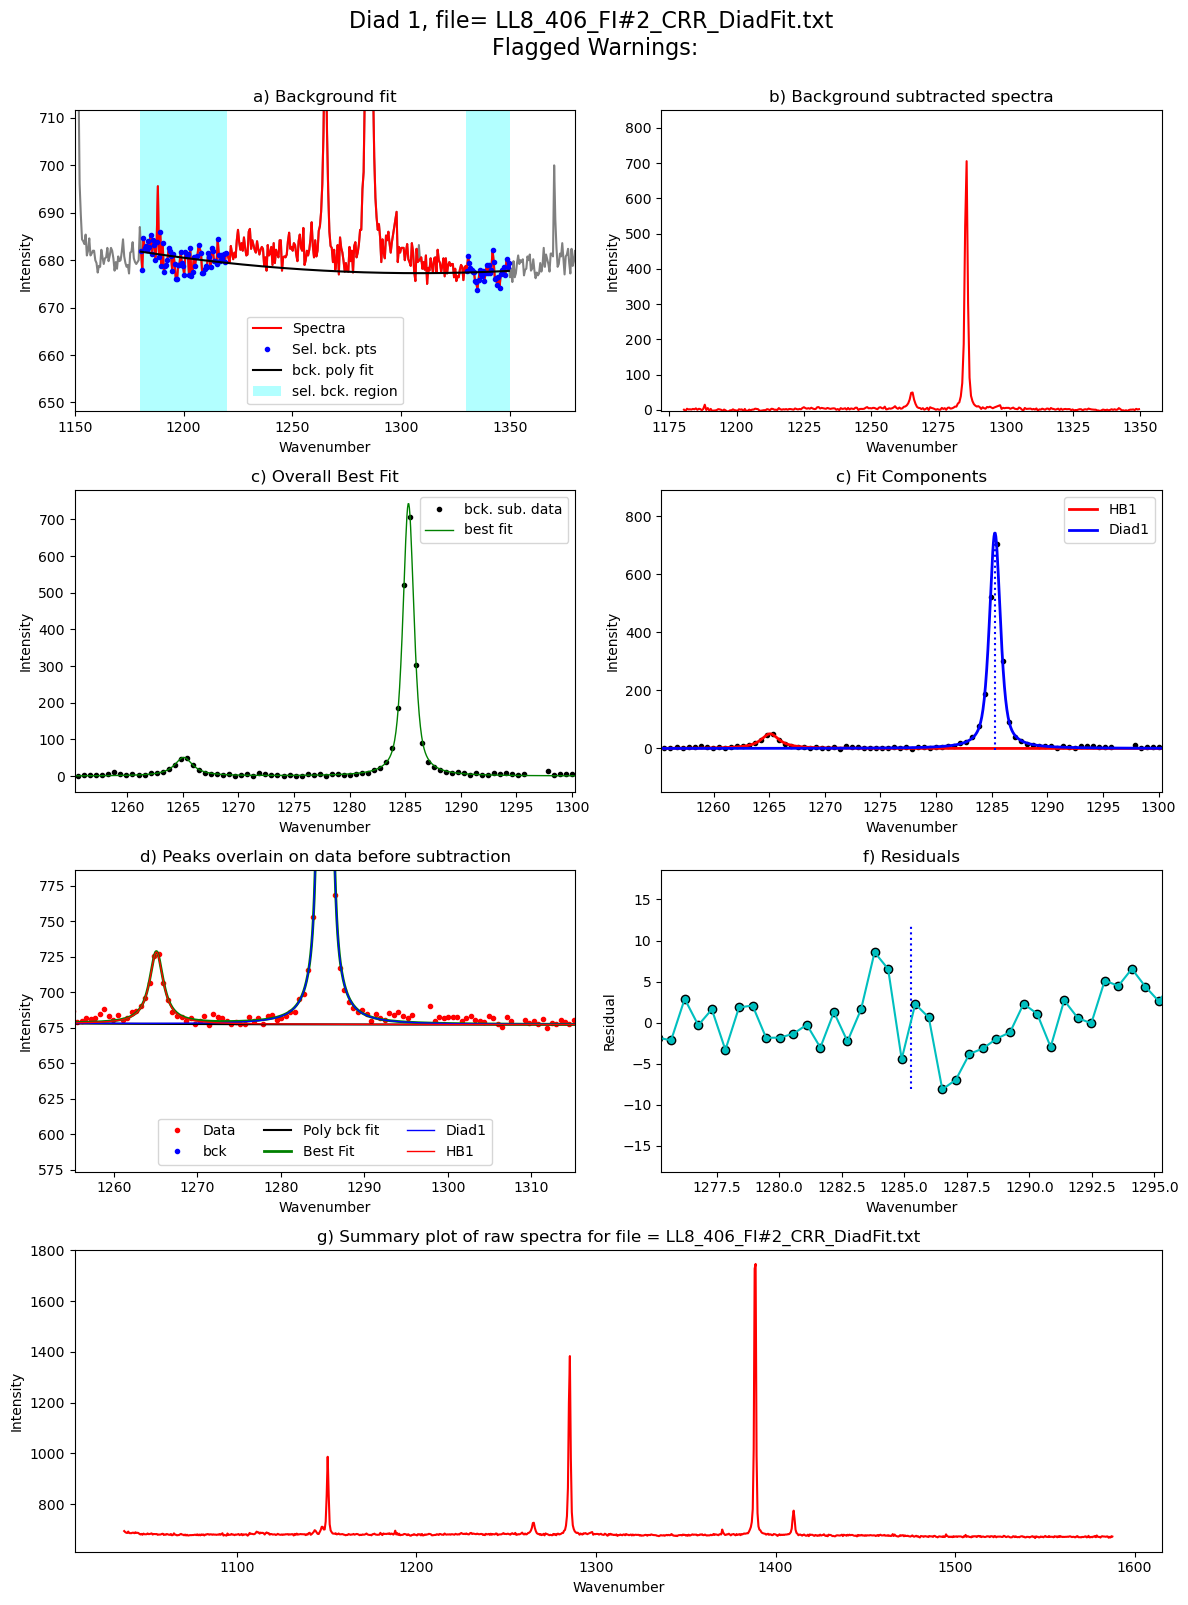

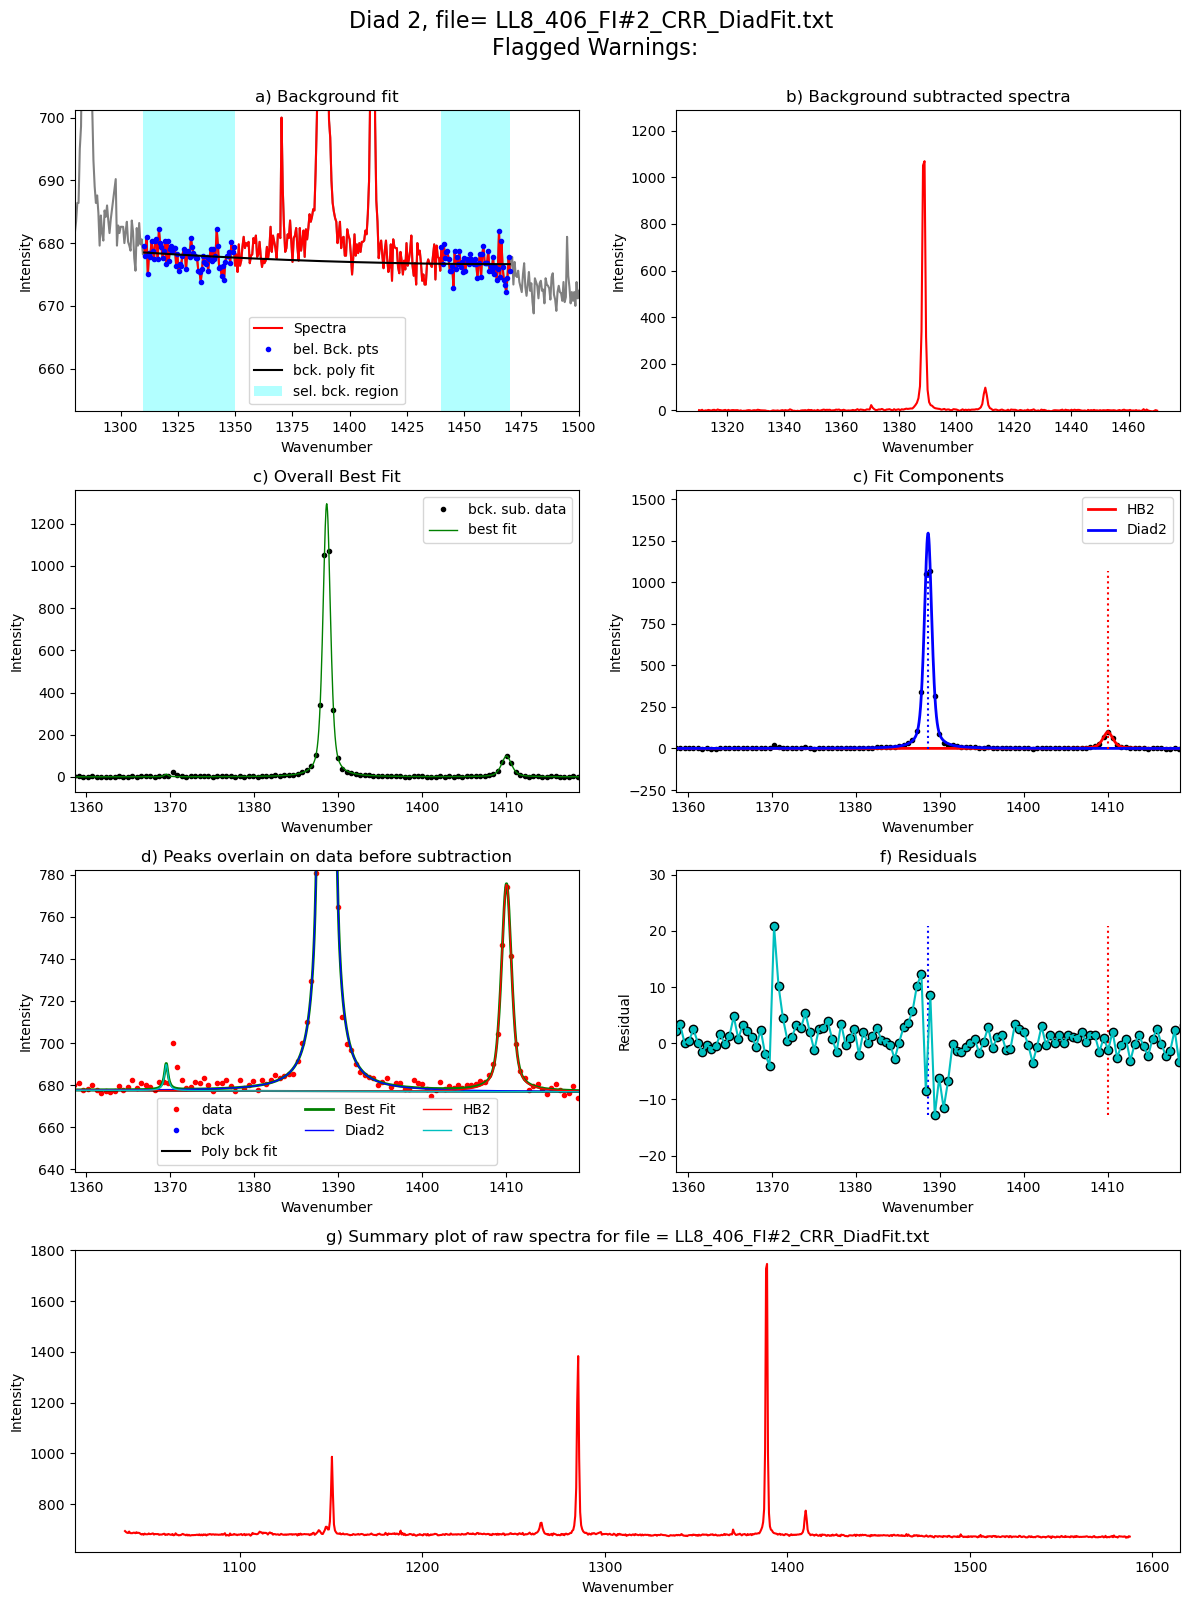

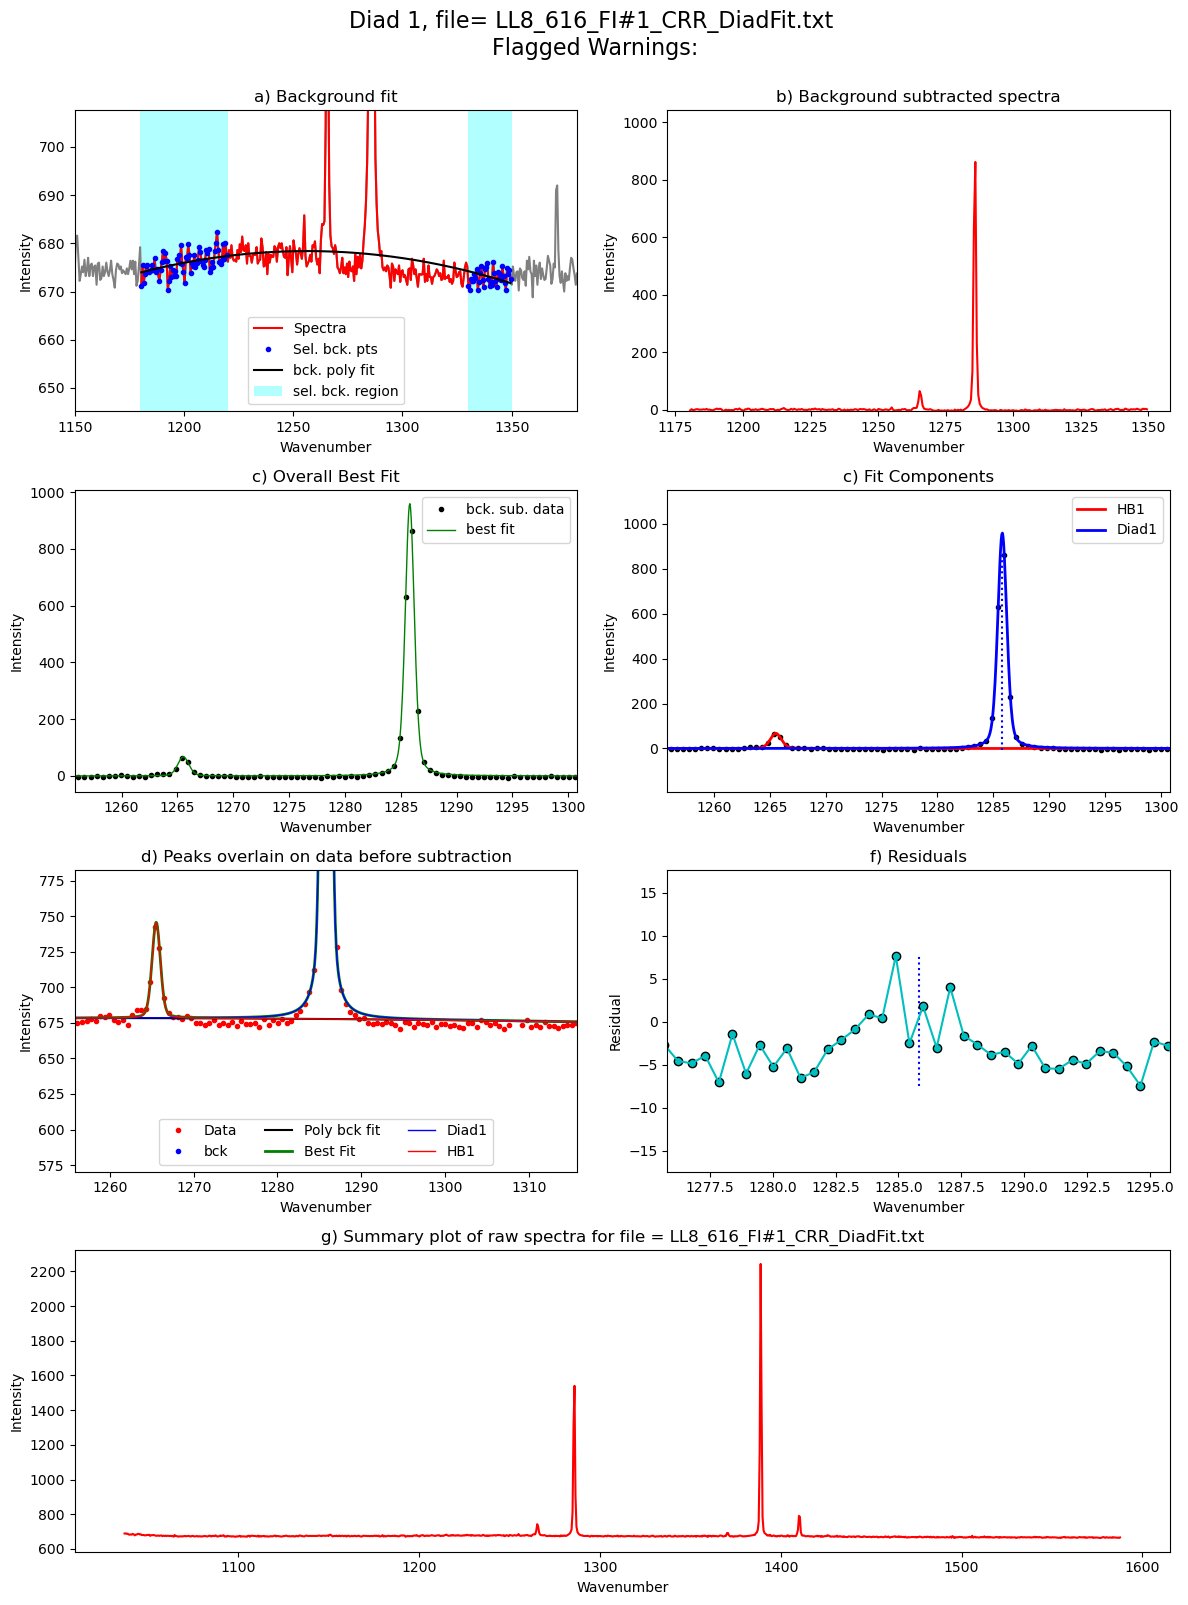

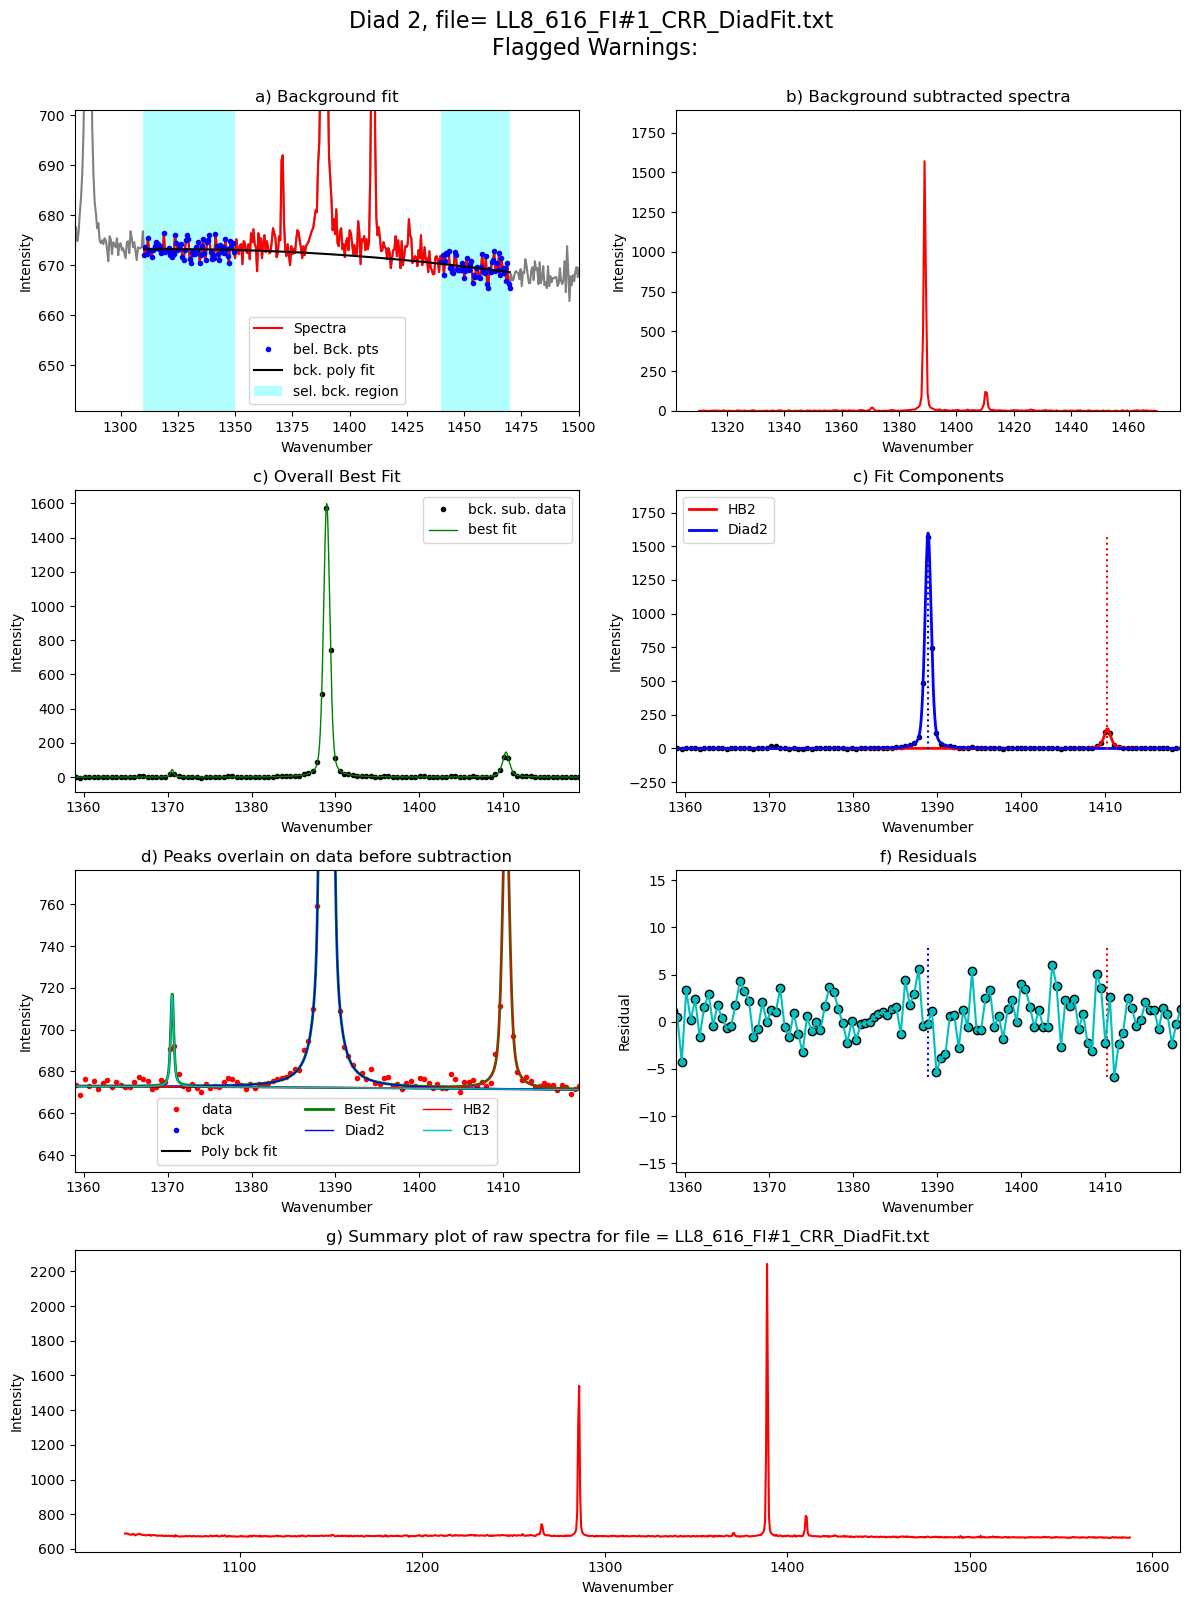

In [35]:
from tqdm import tqdm
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config2.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config2.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config2.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config2.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config2,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0)


### Get file names that flagged a warning

In [36]:
refit_d1=(df_Merge['Diad1_refit']!='Flagged Warnings:')
refit_d2=(df_Merge['Diad2_refit']!='Flagged Warnings:')# (df_Merge['Diad2_refit']==True)
refit=refit_d1|refit_d2
print(sum(refit))
refit_names_1=df_Merge['filename'].loc[refit]
print(refit_names_1)

1
0    LL8_156_FI#5_CRR_DiadFit
Name: filename, dtype: object


### Have a look at different parameters
- This can help you spot really bad fits

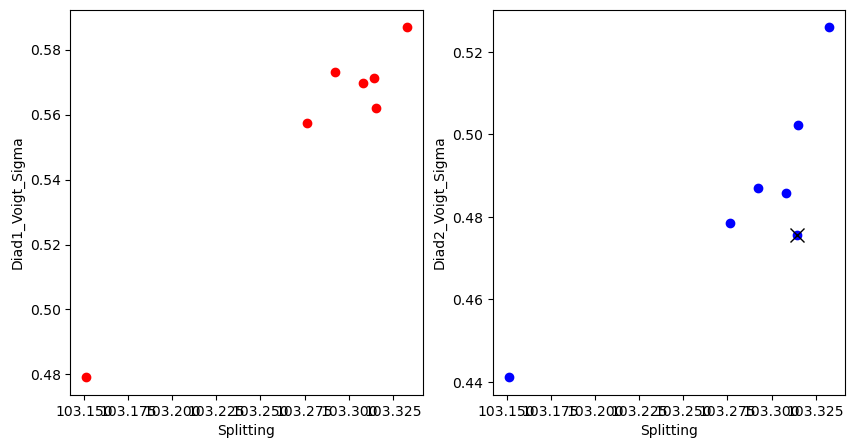

In [37]:
x='Splitting'
y1='Diad1_Voigt_Sigma'
y2='Diad2_Voigt_Sigma'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Merge[x], df_Merge[y1], 'or')
ax2.plot(df_Merge[x], df_Merge[y2], 'ob')
ax1.plot(df_Merge[x].loc[refit_d1], df_Merge[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Merge[x].loc[refit_d2], df_Merge[y2].loc[refit_d2], 'xk', ms=10)
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax1.set_ylabel(y1)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Merge #.loc[(df_Merge['Diad1_Voigt_Area']>25) & (df_Merge['Diad2_Voigt_Area']>30)]

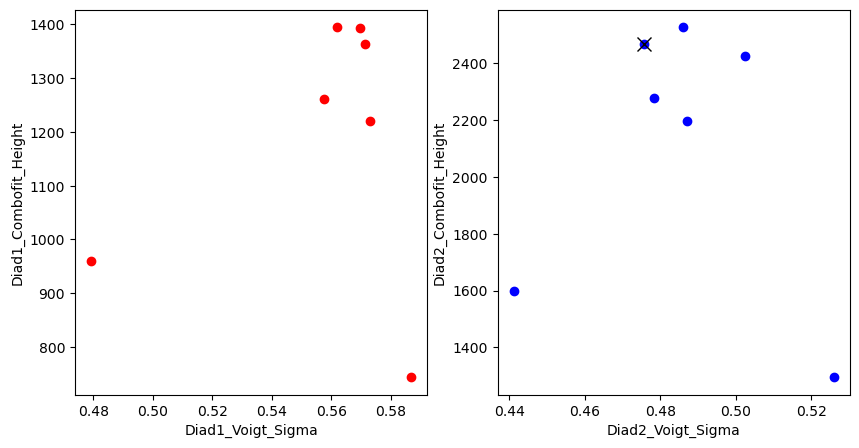

In [38]:
x1='Diad1_Voigt_Sigma'
x2='Diad2_Voigt_Sigma'
y1='Diad1_Combofit_Height'
y2='Diad2_Combofit_Height'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Merge[x1], df_Merge[y1], 'or')
ax2.plot(df_Merge[x2], df_Merge[y2], 'ob')
ax1.plot(df_Merge[x1].loc[refit_d1], df_Merge[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Merge[x2].loc[refit_d2], df_Merge[y2].loc[refit_d2], 'xk', ms=10)

ax1.set_xlabel(x1)
ax1.set_ylabel(y1)
ax2.set_xlabel(x2)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Merge #.loc[(df_Merge['Diad1_Voigt_Area']>25) & (df_Merge['Diad2_Voigt_Area']>30)]

In [39]:
## Save parameters to excel

In [40]:
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx')
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx')
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx')

In [41]:
combo.head()

filename   Splitting  Split_err_abs  \
0                         LL8_156_FI#4  103.292427       0.002538   
0             LL8_156_FI#5_CRR_DiadFit  103.314518       0.001363   
0  LL8_156_FI#5_1320window_CRR_DiadFit  103.308030       0.002423   
0              LL8_156_FI#5_1324window  103.315209       0.002427   
0             LL8_243_FI#1_CRR_DiadFit  103.276463       0.002098   

   Split_err_quadrature  Diad1_Combofit_Cent  Diad1_cent_err  \
0              0.002040          1285.543810        0.001955   
0              0.001363          1285.515752        0.001363   
0              0.001754          1285.425377        0.001478   
0              0.001782          1285.428530        0.001552   
0              0.001584          1285.479965        0.001442   

   Diad1_Combofit_Height  Diad1_Voigt_Cent  Diad1_Voigt_Area  \
0            1220.047768       1285.543860       1877.240666   
0            1362.609407       1285.515802       2057.328368   
0            1392.406943       1285.425427       2095.114124   
0            1394.969752       1285.428580       2105.202833   
0            1262.044472       1285.480015       1853.077485   

   Diad1_Voigt_Sigma  ...  HB2_Sigma     C13_Cent   C13_Area C13_Sigma  \
0           0.572959  ...   0.608526  1370.381402  40.109017  0.243005   
0           0.571352  ...   0.698894          NaN        NaN       NaN   
0           0.569598  ...   0.666089  1371.995128   8.525279  0.242722   
0           0.562049  ...   0.578012  1370.348372  46.116951  0.251046   
0           0.557414  ...   0.667378  1370.507521  36.485630  0.239034   

   Diad2_Gauss_Cent  Diad2_Gauss_Area  Diad2_Gauss_Sigma  Diad1_Gauss_Cent  \
0               NaN               NaN                NaN               NaN   
0               NaN               NaN                NaN               NaN   
0               NaN               NaN                NaN               NaN   
0               NaN               NaN                NaN               NaN   
0               NaN               NaN                NaN               NaN   

   Diad1_Gauss_Area  Diad1_Gauss_Sigma  
0               NaN                NaN  
0               NaN                NaN  
0               NaN                NaN  
0               NaN                NaN  
0               NaN                NaN  

[5 rows x 40 columns]

In [42]:
from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step3_FitAll_Together is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()